<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/7_SHAP_Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5
!pip install --quiet shap==0.39.0

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)
feature_names = mf.get_col(data)

# Model import

## FedMLP

In [5]:
pd.options.mode.chained_assignment = None
X_test = mf.get_set('test_id', data, 'MLP')

**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [6]:
load = True
if load:
  from tensorflow import keras
  model = keras.models.load_model('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/MLP/fed_mlp')

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [7]:
import shap
explainer = shap.KernelExplainer(model.predict, shap.sample(X_test.to_numpy(), 40))

In [9]:
predictions = model.predict(X_test[:100])

In [10]:
indici = [i for i,x in enumerate(predictions) if x>0.5]

In [11]:
lista = np.arange(100,120).tolist()
x = X_test.iloc[indici].to_numpy()
y = X_test.iloc[lista].to_numpy()
z = np.concatenate((x,y), axis=0)
kernel_shap = explainer.shap_values(z)[0] #sono i valori di shapley

In [12]:
def get_highest_shap_values(kernel_shap, id, feature_names, x):
  import operator
  first_shap = kernel_shap[id,:]
  values = {}
  shap_values = {}
  for val in first_shap:
    # if val != 0:
    col_index = first_shap.tolist().index(val)
    values[feature_names[col_index]] = x[id][col_index]
    shap_values[feature_names[col_index]] = val

  sorted_d = dict(sorted(shap_values.items(), key=operator.itemgetter(1), reverse=True))
  # return shap_values, values
  return sorted_d, shap_values, values

def print_shap(sorted_shap_values, values, top_values = 10):
  i = 0
  n = len(sorted_shap_values)
  for col in sorted_shap_values:
    if i <= top_values:
      print(col, 'with value', values[col], 'has shap value', sorted_shap_values[col])
    if i >= n - top_values and sorted_shap_values[col]<0:
      print(col, 'with value', values[col], 'has shap value', sorted_shap_values[col])
    i+=1
  return 

sorted_shap_values, shap_values, values = get_highest_shap_values(kernel_shap, 0, feature_names, x)

In [17]:
datas = []
for col in sorted_shap_values:
  datas.append(values[col])
  datas.append(sorted_shap_values[col])
datas = [datas]

In [18]:
a1 = []
a2 = []
for col in sorted_shap_values:
  for i in range(2):
    a1.append(col)
for i in range(len(a1)):
  if i%2 == 0:
    a2.append('value')
  else:
    a2.append('shap_value')
arrays = [a1,a2]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Feature", "Values"])

In [19]:
df = pd.DataFrame(data=datas, index=['1'], columns=index)

In [20]:
df

Feature R_emaildomain_gmail.com             ... id_15_Found           
Values                    value shap_value  ...       value shap_value
1                           1.0   0.141937  ...         1.0  -0.087762

[1 rows x 128 columns]

In [21]:
kernel_shap.shape

(26, 733)

In [22]:
def shap_force_plot(id, explainer, kernel_shap, feature_names, z):
  shap.initjs()
  return shap.plots.force(explainer.expected_value, kernel_shap[id,:], feature_names=feature_names, features=z[id])
  

In [23]:
shap_force_plot(0, explainer, kernel_shap, feature_names, z)

In [24]:
shap_force_plot(1, explainer, kernel_shap, feature_names, z)

In [25]:
shap_force_plot(2, explainer, kernel_shap, feature_names, z)

In [26]:
shap_force_plot(3, explainer, kernel_shap, feature_names, z)

In [27]:
shap_force_plot(8, explainer, kernel_shap, feature_names, z)

In [28]:
shap_force_plot(12, explainer, kernel_shap, feature_names, z)

In [29]:
shap_force_plot(13, explainer, kernel_shap, feature_names, z)

In [30]:
shap_force_plot(14, explainer, kernel_shap, feature_names, z)

In [31]:
shap_force_plot(15, explainer, kernel_shap, feature_names, z)

In [32]:
shap_force_plot(16, explainer, kernel_shap, feature_names, z)

In [33]:
shap_force_plot(18, explainer, kernel_shap, feature_names, z)

In [34]:
shap_force_plot(19, explainer, kernel_shap, feature_names, z)

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap, feature_names=feature_names, features=X_test.iloc[indici+lista].to_numpy())

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

In [36]:
def shap_decision_plot(id, explainer, kernel_shap, feature_names, z):
  return shap.decision_plot(explainer.expected_value, kernel_shap[id,:], feature_names=feature_names, features=z[id])

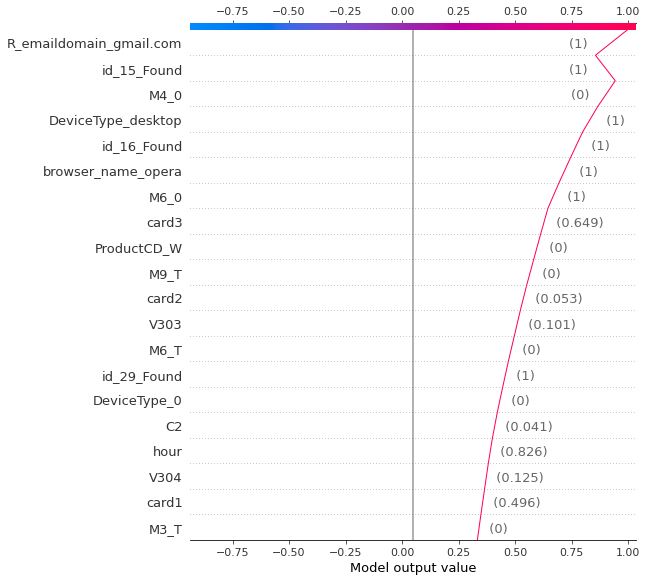

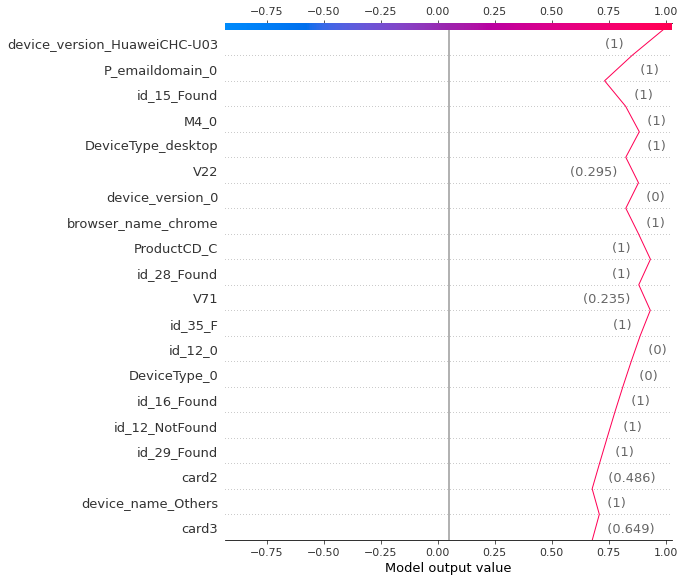

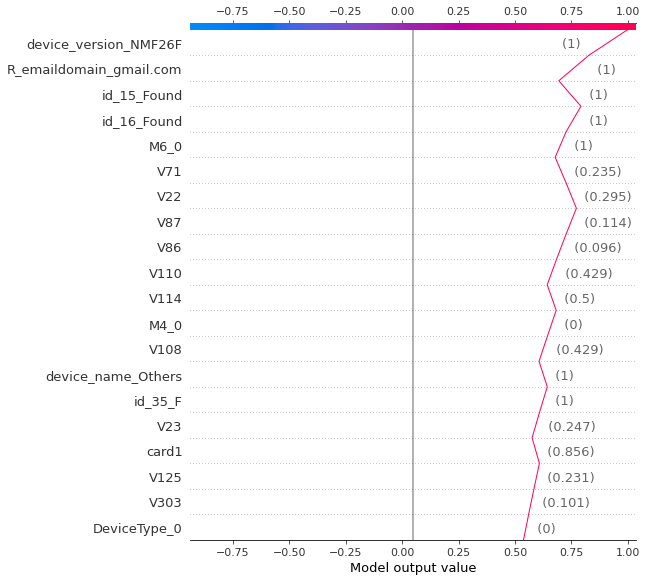

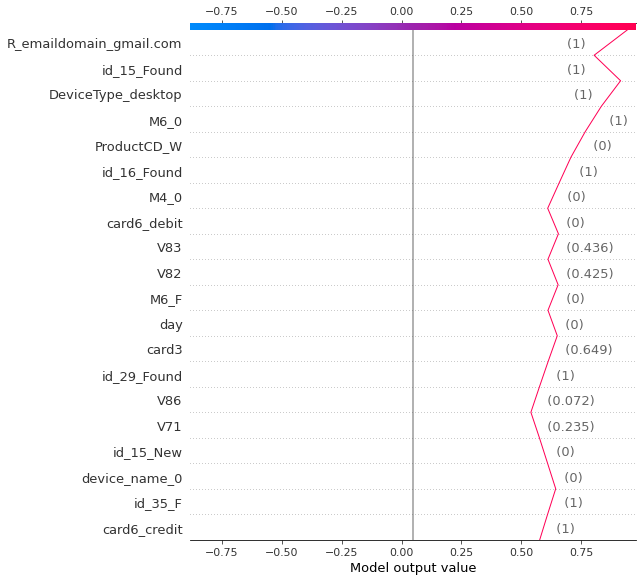

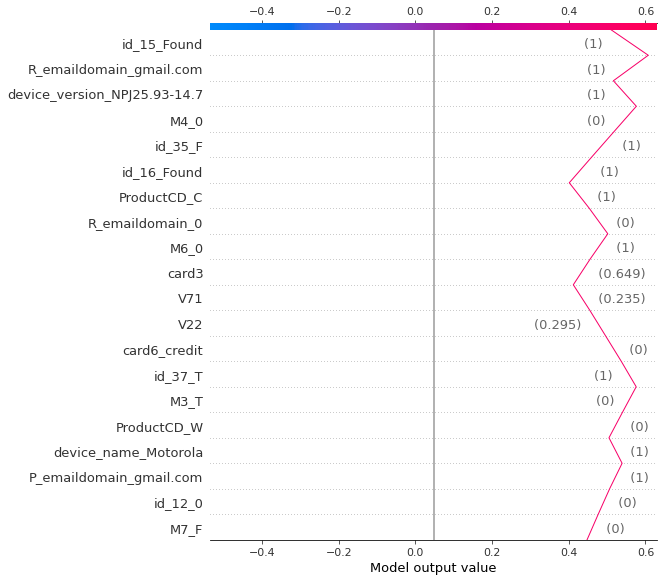

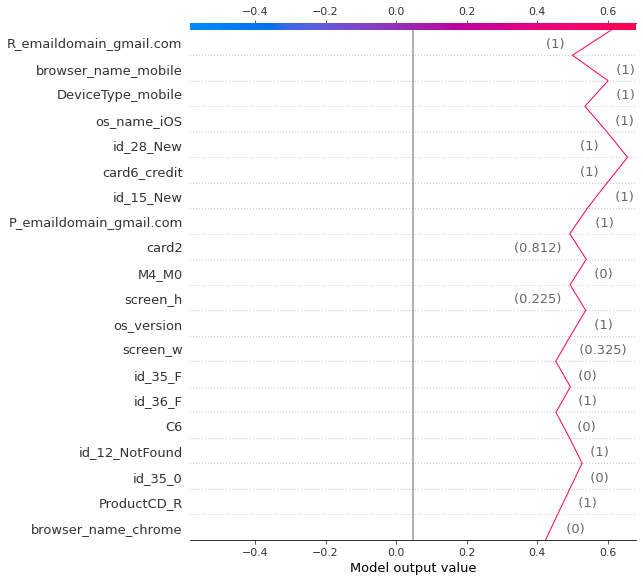

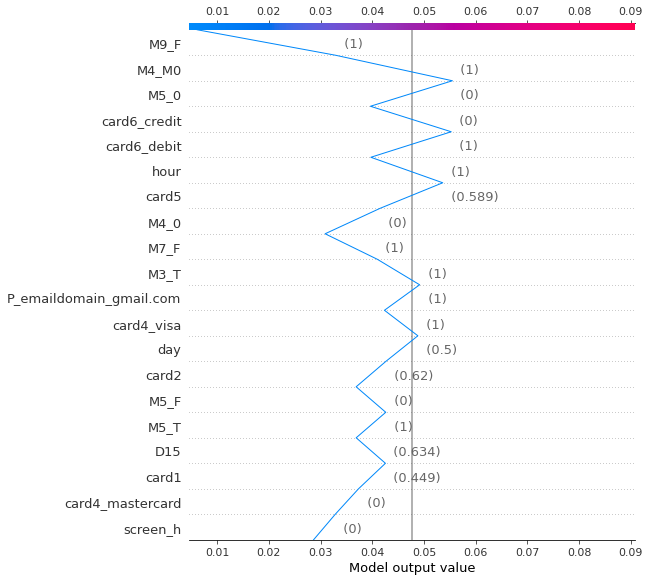

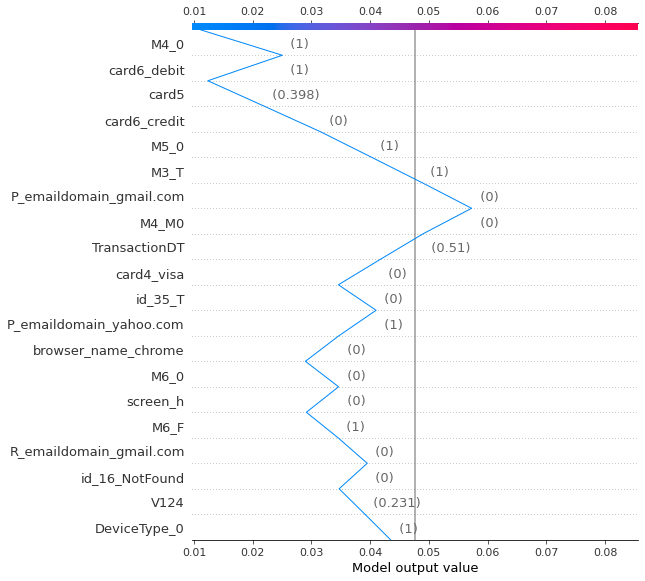

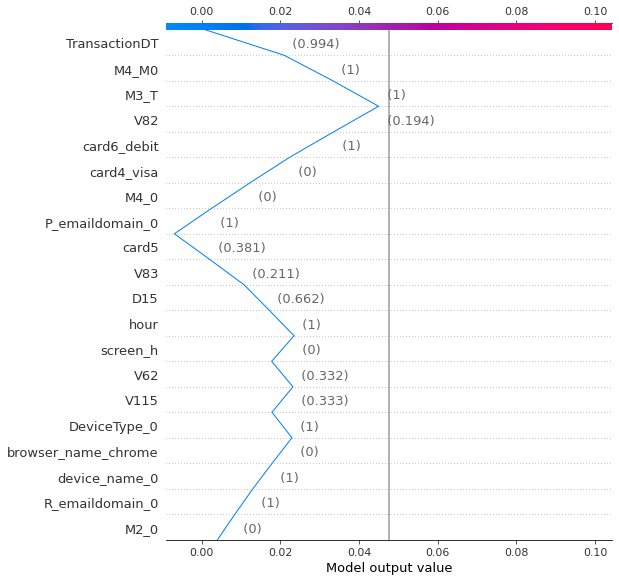

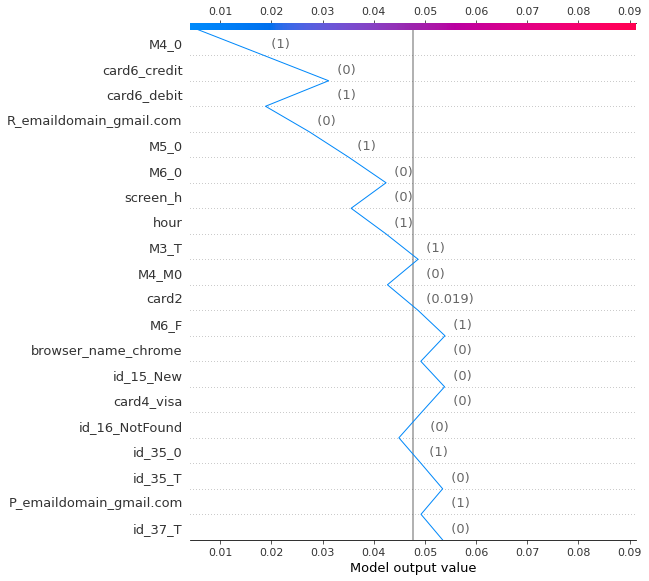

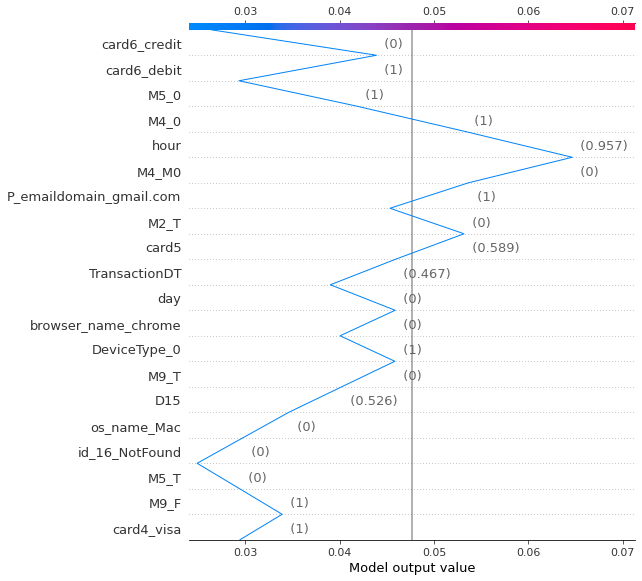

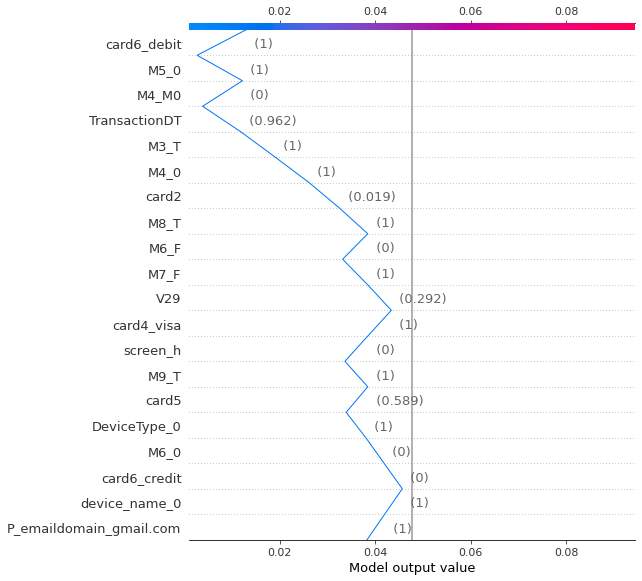

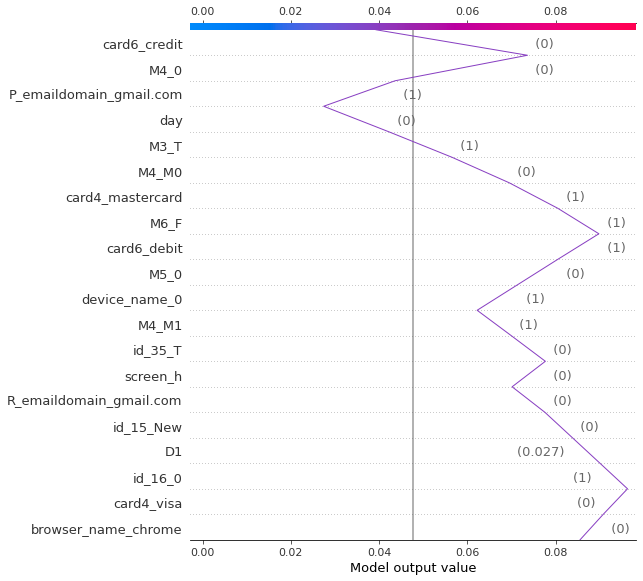

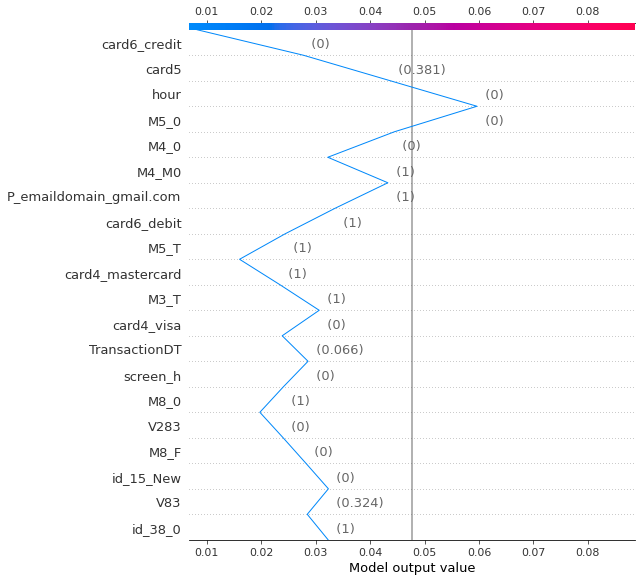

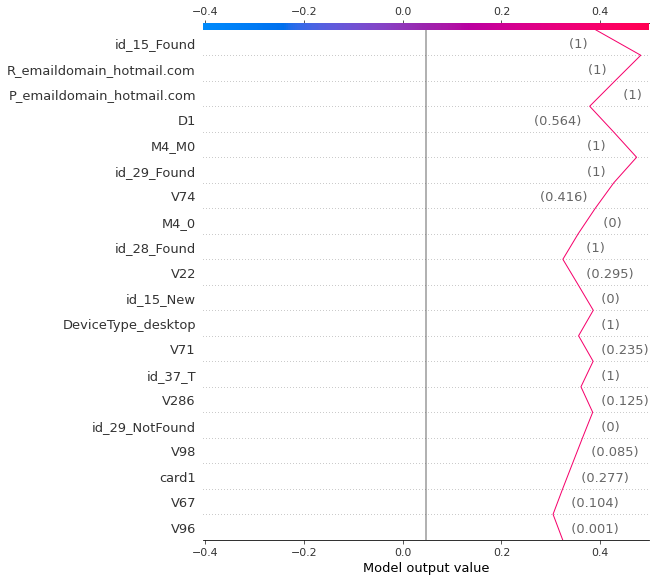

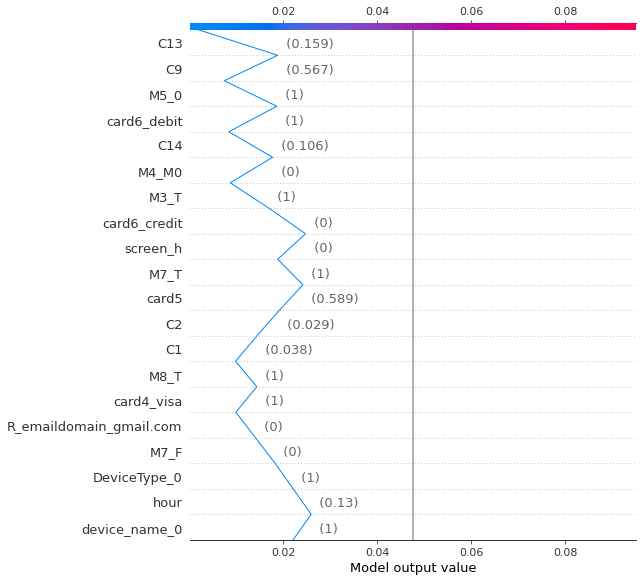

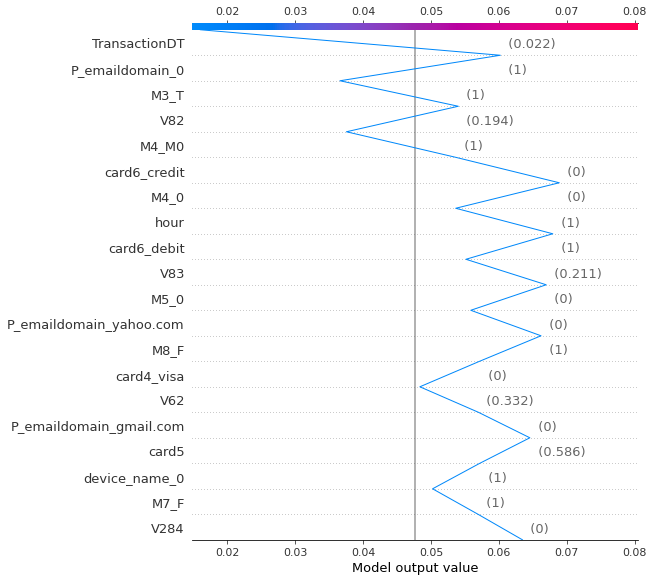

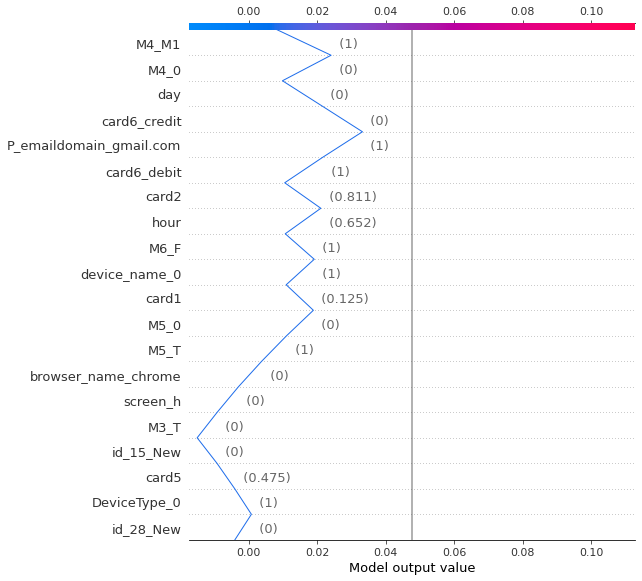

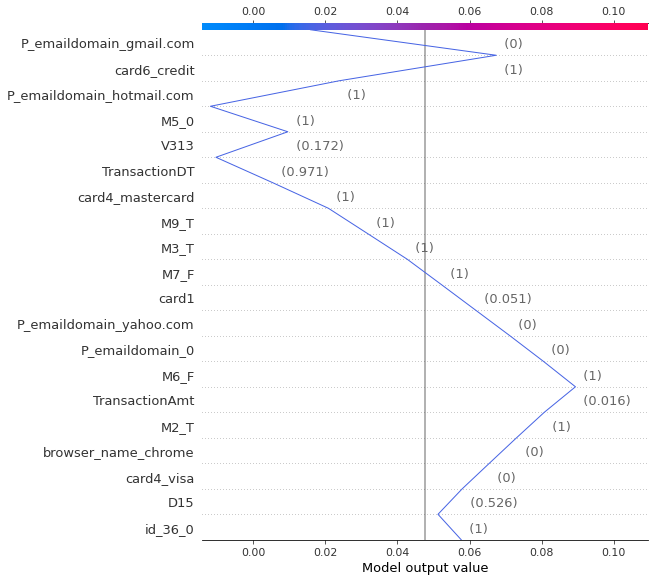

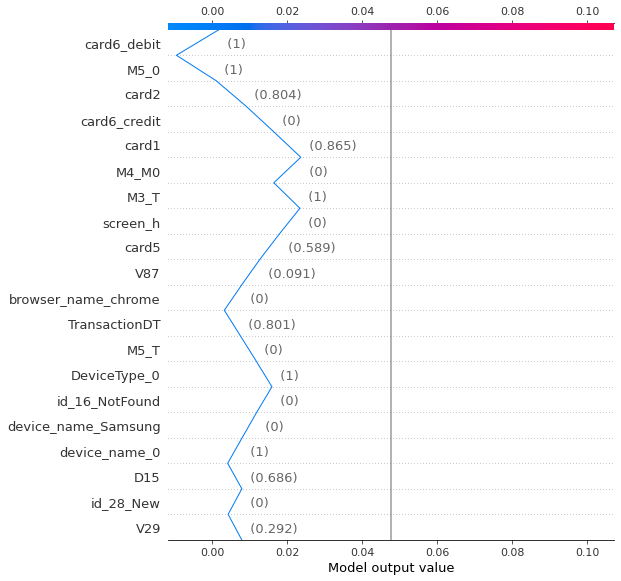

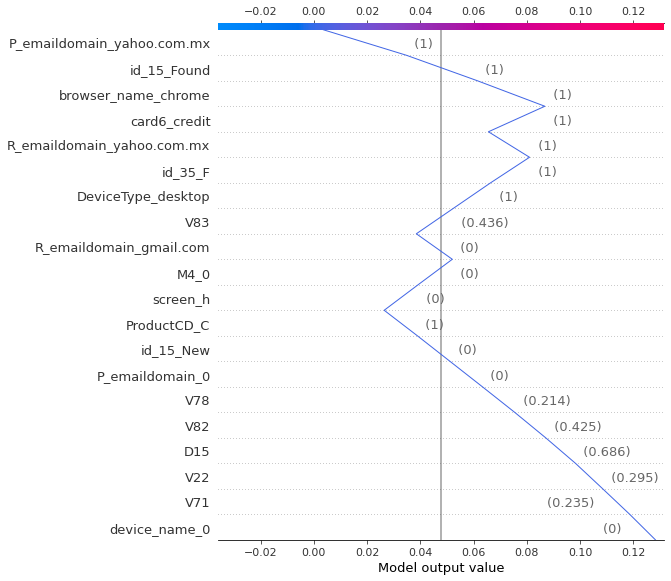

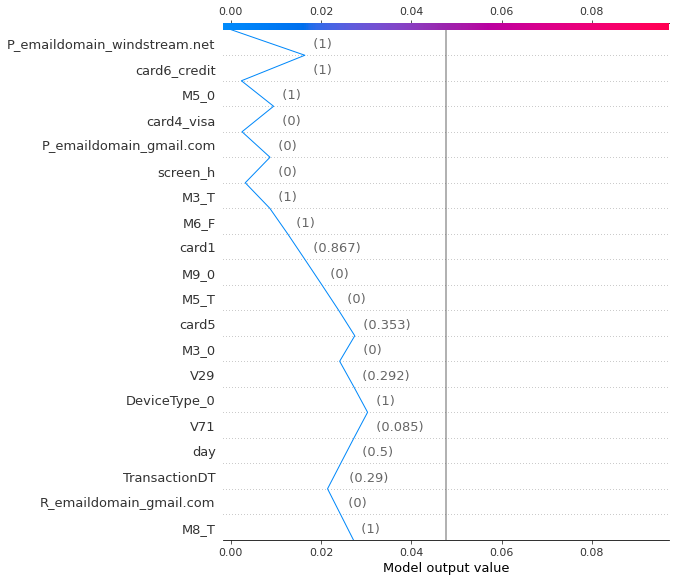

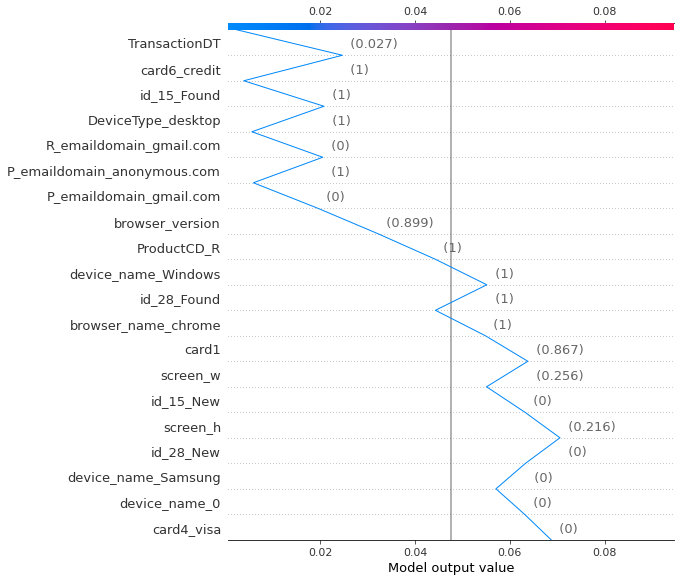

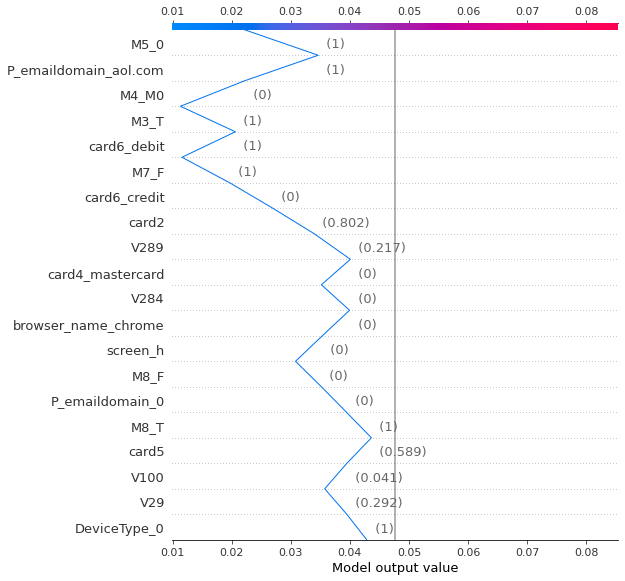

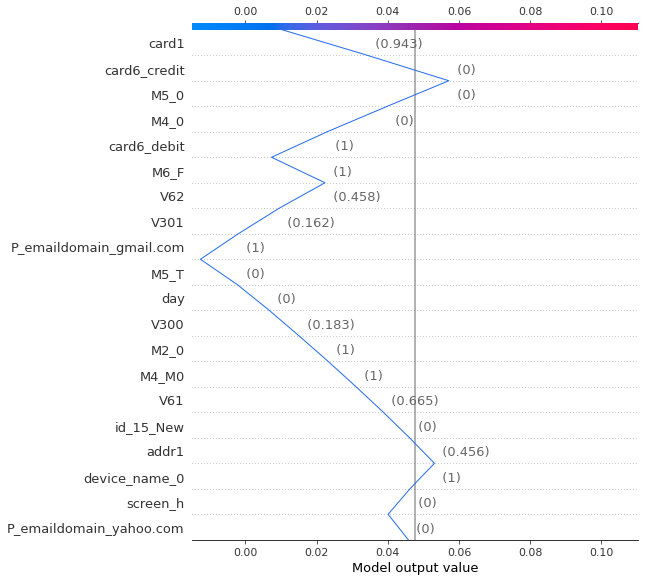

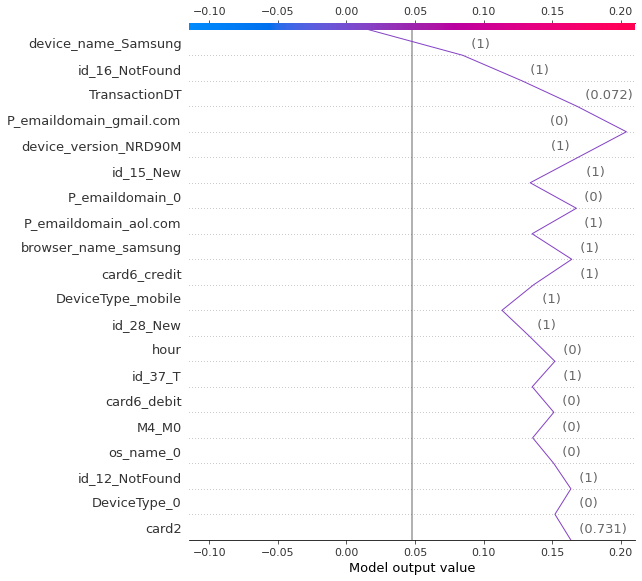

In [37]:
for i in range(kernel_shap.shape[0]):
  shap_decision_plot(i, explainer, kernel_shap, feature_names, z)

In [38]:
summary = np.asmatrix(kernel_shap)

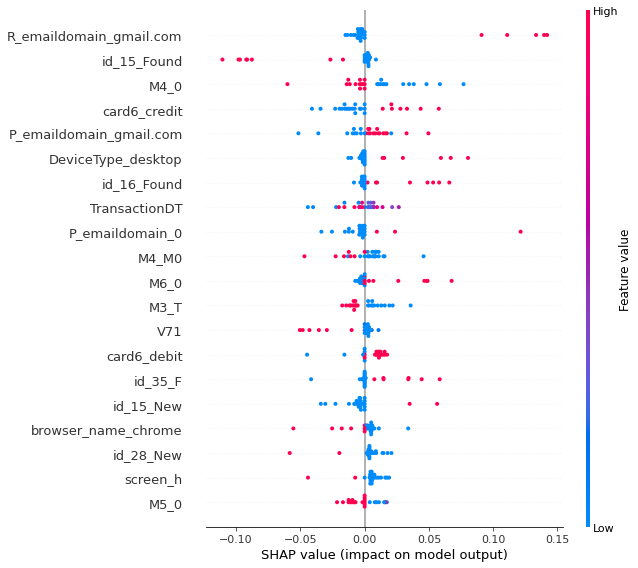

In [39]:
shap.summary_plot(kernel_shap, z, feature_names=feature_names)